In [96]:
import pandas as pd
import importlib
import utilities as utils


activeMode= "prod"

# Reload utils library if changed
importlib.reload(utils)

configuration_csv = pd.read_csv(f"./config/{activeMode}.csv", dtype=str, sep=";")
config = utils.configureParameters(configuration_csv)
max_grad_norm_str = str(config.max_grad_norm).replace(".","-")
print(f"Task: {config.task}")
print(f"Model path: {config.saved_model_path}")
print(f"Data path: {config.data_path}")
print(f"Tokenizer: {config.tokenizer}")
print(f"Batch size: {config.batch_size}")
print(f"Epochs: {config.epochs}")
print(f"Learning rate: {config.learning_rate}")
print(f"Sequence length: {config.sequence_length}")
print(f"Training: {config.train_model}")
print(f"Num Threads: {config.num_threads}")
print(f"Num Sentences: {config.num_sentences}")
print(f"Max Norm: {config.max_grad_norm}")
print(f"Use GNN: {config.use_gnn}")
if(config.use_gnn == True):
    print(f"Num layers: {config.num_layers}")
    print(f"Num attention heads: {config.num_att_heads}")
    print(f"Syntax tree style: {config.use_grammar}")
print(f"Use label weights: {config.use_label_weights}")

Loading model from path bert-base-cased
Task: ner
Model path: bert-base-cased
Data path: ./data/ud/UD_English-GUM/
Tokenizer: bert-base-cased
Batch size: 2
Epochs: 1
Learning rate: 3e-05
Sequence length: 96
Training: True
Num Threads: 4
Num Sentences: 20
Max Norm: 0.0
Use GNN: True
Num layers: 4
Num attention heads: 2
Syntax tree style: dep
Use label weights: True


In [97]:
import os
# Export env vars to limit number of threads to use
num_threads = str(config.num_threads)
os.environ["OMP_NUM_THREADS"] = num_threads 
os.environ["MKL_NUM_THREADS"] = num_threads 

# Only use CPU, hide GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [98]:
import models as models
# Reload models if changed
importlib.reload(models)

<module 'models' from '/home/shrdlu/cdaniel/syntrans/models.py'>

In [99]:
from transformers import BertTokenizer, BertForMaskedLM, BertForTokenClassification, BertConfig, BertModel
import torch
import torch.nn as nn
import torch.nn.functional as F
#Import SummaryWriter for Tensorboard logging
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import (DataLoader, TensorDataset)
# Load Pytorch Geometric
from torch_geometric.data import Data
import torch_geometric.data as tg_data
import torch_geometric.loader as tg_loader
import torch_geometric.utils as tg_utils
import torch_geometric.nn as tg_nn
import torch.profiler
from torch.profiler import profile, record_function, ProfilerActivity
import evaluate
# Evaluation metrics for NER task
from seqeval.metrics import classification_report
# Support for IOBES style NER labels
from seqeval.scheme import IOBES
import numpy as np
# Progress bar
from tqdm import tqdm
# Easy file reading
import glob
import random
import pickle
import matplotlib.pyplot as plt
import math
from sklearn.utils.class_weight import compute_class_weight
import datetime

In [100]:
PID = os.getpid()
PGID = os.getpgid(PID)
print(f"PID: {PID}, PGID: {PGID}")

PID: 3570, PGID: 116


In [101]:
# Limit no. of threads used by Pytorch
torch.set_num_threads = int(num_threads)
torch.set_num_interop_threads = int(num_threads)
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [102]:
print(torch.__config__.parallel_info())

ATen/Parallel:
	at::get_num_threads() : 2
	at::get_num_interop_threads() : 2
OpenMP 201511 (a.k.a. OpenMP 4.5)
	omp_get_max_threads() : 2
Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
	mkl_get_max_threads() : 2
Intel(R) MKL-DNN v2.5.2 (Git Hash a9302535553c73243c632ad3c4c80beec3d19a1e)
std::thread::hardware_concurrency() : 4
Environment variables:
	OMP_NUM_THREADS : 4
	MKL_NUM_THREADS : 4
ATen parallel backend: OpenMP



In [103]:
ner_tags_list = ['X','O','<unk>', 'B-CARDINAL', 'E-CARDINAL', 'S-PERSON', 'S-CARDINAL', 'S-PRODUCT', 'B-PRODUCT', 'I-PRODUCT', 'E-PRODUCT', 'B-WORK_OF_ART', 'I-WORK_OF_ART', 'E-WORK_OF_ART', 'B-PERSON', 'E-PERSON', 'S-GPE', 'B-DATE', 'I-DATE', 'E-DATE', 'S-ORDINAL', 'S-LANGUAGE', 'I-PERSON', 'S-EVENT', 'S-DATE', 'B-QUANTITY', 'E-QUANTITY', 'S-TIME', 'B-TIME', 'I-TIME', 'E-TIME', 'B-GPE', 'E-GPE', 'S-ORG', 'I-GPE', 'S-NORP', 'B-FAC', 'I-FAC', 'E-FAC', 'B-NORP', 'E-NORP', 'S-PERCENT', 'B-ORG', 'E-ORG', 'B-LANGUAGE', 'E-LANGUAGE', 'I-CARDINAL', 'I-ORG', 'S-WORK_OF_ART', 'I-QUANTITY', 'B-MONEY', 'I-MONEY', 'E-MONEY', 'B-LOC', 'E-LOC', 'I-LOC', 'B-PERCENT', 'I-PERCENT', 'E-PERCENT', 'S-LOC', 'S-FAC', 'B-EVENT', 'E-EVENT', 'I-EVENT', 'S-MONEY', 'B-LAW', 'I-LAW', 'E-LAW', 'I-NORP', 'I-LANGUAGE', 'S-LAW', 'S-QUANTITY', 'B-ORDINAL', 'I-ORDINAL', 'E-ORDINAL', '<START>', '<STOP>', "[CLS]", "[SEP]"]
num_ner_labels = len(ner_tags_list)

In [104]:
# Filepath for sentences
filepath_train_data = config.data_path + f'**/*-train.txt'
filepath_validation_data = config.data_path + f'**/*-dev.txt'
filepath_test_data = config.data_path + f'**/*-test.txt'

# Filepath for syntax graphs
filepath_train_syntrees = config.data_path + f'**/*-train-{config.tokenizer}.syntree'
filepath_validation_syntrees = config.data_path + f'**/*-dev-{config.tokenizer}.syntree'
filepath_test_syntrees = config.data_path + f'**/*-test-{config.tokenizer}.syntree'

# Filepath for sentences with NER tags
filepath_train_ner_labels = config.data_path + f'**/*-train-orig.ner'
filepath_validation_ner_labels = config.data_path + f'**/*-dev-orig.ner'
filepath_test_ner_labels = config.data_path + f'**/*-test-orig.ner'

In [105]:
date = datetime.datetime.now()
month_day = date.strftime("%m_%d")
general_config = f"{month_day}_{config.tokenizer}_E{config.epochs}_batches{config.batch_size}_LR{config.learning_rate}_SL{config.sequence_length}_GN{max_grad_norm_str}"

if (config.use_gnn == True):
    tensorboard_dir = f"./runs/{config.task}/synGNN/{config.use_grammar}/{general_config}_TL_{config.num_layers}AttH_{config.num_att_heads}_LW{config.use_label_weights}"
    tensorboard_dir = utils.createNumberedDir(tensorboard_dir)

    results_dir = f"./logs/{config.task}/synGNN/{config.use_grammar}/{general_config}__TL_{config.num_layers}AttH_{config.num_att_heads}_LW{config.use_label_weights}"
    results_dir = utils.createNumberedDir(results_dir)
    if (activeMode == "prod"):
        trained_models_dir = f"./trained_models/{config.task}/synGNN/{config.use_grammar}/{general_config}_TL_{config.num_layers}AttH_{config.num_att_heads}_LW{config.use_label_weights}"
        trained_models_dir = trained_models_dir.replace(f"_E{config.epochs}_", f"_E0_")
else:
    tensorboard_dir = f"./runs/{config.task}/bert/{general_config}"
    tensorboard_dir = utils.createNumberedDir(tensorboard_dir)

    results_dir = f"./logs/{config.task}/bert/{general_config}"
    results_dir = utils.createNumberedDir(results_dir)
    if (activeMode == "prod"):
        trained_models_dir = f"./trained_models/{config.task}/bert/{general_config}"
        trained_models_dir = trained_models_dir.replace(f"_E{config.epochs}_", f"_E0_")
        


In [106]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_ids, valid_ids=None, label_mask=None):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_ids = label_ids
        self.valid_ids = valid_ids
        self.label_mask = label_mask

In [107]:
def create_masked_inputs(inputs):
    """
    creates masked input embeddings and labels from tokenized text

    :param inputs: tokenized text
    :return: InputFeatures list with masked input embeddings, new column labels and Bert attention mask/segment ids
    """ 

    features = []
    # Clone input ids (tokens) to create labels
    inputs['labels'] = inputs.input_ids.detach().clone()
    # create random array of floats with equal dimensions to input_ids tensor
    rand = torch.rand(inputs.input_ids.shape)
    # create mask array with 15% masked tokens
    mask_arr = (rand < 0.15) * (inputs.input_ids != 101) * \
        (inputs.input_ids != 102) * (inputs.input_ids != 0)
    # Select indices of each nonzero (= selected) value as token to be masked
    selection = []

    for i in range(inputs.input_ids.shape[0]):
        selection.append(
            torch.flatten(mask_arr[i].nonzero()).tolist()
        )
    # Mask selected tokens: replace with [MASK] code 103 in tensor
    for i in range(inputs.input_ids.shape[0]):
        inputs.input_ids[i, selection[i]] = 103
    
    features.append(
        InputFeatures(
                        input_ids=inputs.input_ids,
                        input_mask=inputs.attention_mask,
                        segment_ids=inputs.token_type_ids,
                        label_ids=inputs.labels
                        ))
    return inputs

In [108]:
def calculate_label_weights(label_ids_sample,num_labels, create_label_weights, label_weights_clip):
    all_label_weights = np.ones(num_labels)
    # Set weights for label classes to 1 (=no change) 
    if create_label_weights == 1:
        #print("Lavel ids sample:")
        #print(label_ids_sample)
        bincount = np.bincount(label_ids_sample)
        bincount = np.where(bincount == 0, 1, bincount)

        #print(bincount.size())
        bincount = np.array(bincount, dtype=np.float64)
        num_samples = len(label_ids_sample)
        
        
        all_label_weights = num_samples / (num_labels * bincount)
        print(all_label_weights)

        #max_ner = np.max(bincount[2:77])
        #all_label_weights = np.reciprocal(bincount+1)*(max_ner+1)
        # Cap weight values at clip value
        #all_label_weights = np.clip(all_label_weights,None,label_weights_clip)
        # Reduce weight of X and O, CLS, SEP for loss computation
        # Run om 18.09 with weights calculated from sample of 750 sentences
        #all_label_weights[0] = 0.04
        #all_label_weights[1] = 0.0125
        #all_label_weights[77] = 0.2
        #all_label_weights[78] = 0.2

        # Run om 19.09 with weights calculated from all sentences
        #all_label_weights[0] = 0.04
        #all_label_weights[1] = 0.017
        #all_label_weights[77] = 0.1
        #all_label_weights[78] = 0.1
    
        #sum = np.sum(bincount)
        #sum_X = bincount[0]
        #sum_O = bincount[1]
        #sum_ner = np.sum(bincount[2:77])
        #sum_SEP_CLS = np.sum(bincount[77:79])


        #print(f" {bincount}")
        #print(f"Total:{sum}")
        #print(f"X: {sum_X}")
        #print(f"O: {sum_O}")
        #print(f"NER {sum_ner}")
        #print(f"SEP/CLS: {sum_SEP_CLS}")

        '''label_classes = np.unique(all_label_ids)
        label_weights = compute_class_weight(class_weight='balanced', classes=label_classes, y=np.array(all_label_ids).reshape(-1))

        for idx, label_weight in enumerate(label_weights):
            label_class = label_classes[idx]
            all_label_weights[label_class] = label_weight'''

        with open("./temp/label_weights_ud.txt", "w") as output:
            output.write(str(all_label_weights))
    return torch.tensor(all_label_weights, dtype=torch.float)

In [109]:
def create_ner_input_features(sentence_labels_list, label_list, seq_length, tokenizer, create_label_weights = False):
    """Loads a list of sentences into a list of input features for the transformer
    
        :return: list of inpt features objects
    """

    # Map NER labels to indices
    label_map = {label : i for i, label in enumerate(label_list,0)}

    features = []
    all_label_ids = []
    for (sentence_idx,sentence_label_pair) in enumerate(sentence_labels_list):
        # Tokenized text of sentence
        tokens = []
        # Token labels for sentence
        labels = []
        # Lists valid labels as 1 and labels to be ignored as 0 (e.g. for the labels for subword tokens which are not counting as separate labels for each token)
        valid = []
        # Mask for transformer indicating which tokens to ignore
        label_mask = []
        for word_label_pair in sentence_label_pair:
            token = tokenizer.tokenize(word_label_pair[0])
            tokens.extend(token)

            label_word = word_label_pair[1]
            for token_idx in range(len(token)):
                # Append label for first token in word, mark as valid
                if token_idx == 0:
                    labels.append(label_word)
                    valid.append(1)
                    label_mask.append(1)
                # Subword tokens: Mark as not valid
                else:
                    labels.append('X')
                    valid.append(0)
                    label_mask.append(1)
        # Sentence exceeds max sequence length: cut to sequence length
        if len(tokens) > seq_length-2:
            tokens = tokens[0:(seq_length-2)]
            labels = labels[0:(seq_length-2)]
            valid = valid[0:(seq_length-2)]
            label_mask = label_mask[0:(seq_length-2)]
            if len(tokens)>94:
                print(tokens)
        # Tokens with BERT [CLS] and [SEP] tokens
        ntokens = []
        # Segment ids for BERT
        segment_ids = []
        # Label embedding ids for BERT
        label_ids = []
        # Start segment
        ntokens.append("[CLS]")
        segment_ids.append(0)
        # Add CLS token label for Bert
        label_ids.append(label_map["[CLS]"])
        # Mark as valid label
        valid.insert(0,1)
        label_mask.insert(0,1)

        # add sentence tokens and label ids
        for i, token in enumerate(tokens):
            ntokens.append(token)
            segment_ids.append(0)
            if len(labels) > i:
                label_ids.append(label_map[labels[i]])
        # End segment
        ntokens.append("[SEP]")
        segment_ids.append(0)

        # Add SEP end token label for Bert
        label_ids.append(label_map["[SEP]"])
        valid.append(1)
        label_mask.append(1)

        # Convert tokens to ids
        input_ids = tokenizer.convert_tokens_to_ids(ntokens)
        input_mask = [1] * len(input_ids)

        # Add label ids to list for weight computation
        all_label_ids.extend(label_ids)
        
        # Pad sentence to sequence length
        while len(input_ids) < seq_length:
            input_ids.append(0)
            input_mask.append(0)
            segment_ids.append(0)

        # Pad labels to sequence length
        while len(label_ids) < seq_length:
            label_ids.append(0)
            label_mask.append(0)
            valid.append(1)
        
        try:
            assert len(input_ids) == seq_length
            assert len(input_mask) == seq_length
            assert len(segment_ids) == seq_length
            assert len(label_ids) == seq_length
            assert len(valid) == seq_length
            assert len(label_mask) == seq_length
        except Exception as e:
            print(repr(e))
            len(input_ids)


        features.append(
        InputFeatures(
                        input_ids=input_ids,
                        input_mask=input_mask,
                        segment_ids=segment_ids,
                        label_ids=label_ids,
                        valid_ids=valid,
                        label_mask=label_mask,
                        ))
    num_labels = len(label_list)
    all_label_weights = calculate_label_weights(all_label_ids, num_labels, create_label_weights, config.label_weights_clip)

    return features, all_label_weights


In [110]:
class MlmDataset(torch.utils.data.Dataset):
    def __init__(self, features, syntax_graphs=None,sentence_graph_idx_maps=None):
        #self.features = features
        self.input_ids = features['input_ids']
        self.input_masks = features['attention_mask']
        self.label_ids = features['labels']
        self.segment_ids = features['token_type_ids']
        self.syntax_graphs = syntax_graphs
        self.sentence_graph_idx_maps = sentence_graph_idx_maps
        
    def __getitem__(self, idx):

        input_ids = torch.squeeze(self.input_ids[idx])
        input_masks = torch.squeeze(self.input_masks[idx])
        label_ids = torch.squeeze(self.label_ids[idx])
        segment_ids = torch.squeeze(self.segment_ids[idx])
        if(self.syntax_graphs is not None and self.sentence_graph_idx_maps is not None):

            syntax_graphs = self.syntax_graphs[idx]
            sentence_graph_idx_map = self.sentence_graph_idx_maps[idx]
            return input_ids, input_masks, label_ids, segment_ids, syntax_graphs, sentence_graph_idx_map
        else:
            return input_ids, input_masks, label_ids, segment_ids
            
    def __len__(self):
        return len(self.input_ids)

In [111]:
def mlm_data_collate_function(data):

    # Get all Bert input feature objects
    if config.use_gnn == True:
        input_features = list(zip(*data))[0]
    else:
        input_features = data
    # Get all input ids
    input_ids = torch.squeeze(torch.tensor(list(map(lambda x:x.input_ids,input_features)),dtype=torch.long))

    # Get all input masks
    input_masks = torch.squeeze(torch.tensor(list(map(lambda x:x.attention_mask,input_features)),dtype=torch.long))

    # Get all label ids
    label_ids = torch.squeeze(torch.tensor(list(map(lambda x:x.labels,input_features)),dtype=torch.long))

    # Get all segment ids
    segment_ids = torch.squeeze(torch.tensor(list(map(lambda x:x.token_type_ids,input_features)),dtype=torch.long))

    if config.use_gnn == True:
        # Get all Pytorch Geom Data objects
        pyg_data = list(zip(*data))[1]
        # Get all sentence_graph_idx_maps
        sentence_graph_idx_maps = list(zip(*data))[2]

        return input_ids, input_masks, label_ids, segment_ids, pyg_data, sentence_graph_idx_maps
    else:
        return input_ids, input_masks, label_ids, segment_ids

In [112]:
class NerDataset(torch.utils.data.Dataset):
    def __init__(self, features, syntax_graphs=None,sentence_graph_idx_maps=None):

        self.features = features
        self.syntax_graphs = syntax_graphs
        self.sentence_graph_idx_maps = sentence_graph_idx_maps

    def __getitem__(self, idx):

        if(self.syntax_graphs is not None and self.sentence_graph_idx_maps is not None):

            features = self.features[idx]
            syntax_graphs = self.syntax_graphs[idx]
            sentence_graph_idx_map = self.sentence_graph_idx_maps[idx]
            return features, syntax_graphs, sentence_graph_idx_map
        else:
            return self.features[idx]
        
    def __len__(self):
        return len(self.features)

In [113]:
def ner_data_collate_function(data):

    # Get all Bert input feature objects
    if config.use_gnn == True:
        input_features = list(zip(*data))[0]
    else:
        input_features = data
    # Get all input ids
    input_ids = torch.squeeze(torch.tensor(list(map(lambda x:x.input_ids,input_features)),dtype=torch.long))

    # Get all input masks
    input_masks = torch.squeeze(torch.tensor(list(map(lambda x:x.input_mask,input_features)),dtype=torch.long))

    # Get all label ids
    label_ids = torch.squeeze(torch.tensor(list(map(lambda x:x.label_ids,input_features)),dtype=torch.long))

    # Get all valid ids
    valid_ids = torch.squeeze(torch.tensor(list(map(lambda x:x.valid_ids,input_features)),dtype=torch.long))

    # Get all label masks
    label_masks = torch.squeeze(torch.tensor(list(map(lambda x:x.label_mask,input_features)),dtype=torch.long))

    # Get all segment ids
    segment_ids = torch.squeeze(torch.tensor(list(map(lambda x:x.segment_ids,input_features)),dtype=torch.long))

    if config.use_gnn == True:
        # Get all Pytorch Geom Data objects
        pyg_data = list(zip(*data))[1]
        # Get all sentence_graph_idx_maps
        sentence_graph_idx_maps = list(zip(*data))[2]

        return input_ids, input_masks, label_ids, valid_ids, label_masks, segment_ids, pyg_data, sentence_graph_idx_maps
    else:
        return input_ids, input_masks, label_ids, valid_ids, label_masks, segment_ids

In [114]:
def train_ud_tokenizer(tokenizer, tokenizer_name):
    tokenizer_path = "./tokenizers/" + tokenizer_name 
    special_tokens = [
  "[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]", "<S>", "<T>"
    ]
    # 30,522 vocab is BERT's default vocab size, feel free to tweak
    vocab_size = 30_522
    # Load data
    text = []
    for ud_file in glob.iglob(config.data_path + '**/UD_English-Pronouns/en_*.txt', recursive=True):

        ud_file = os.path.abspath(ud_file)
        filename = os.path.basename(ud_file)
        print(filename, flush = True)
        tokenizer.train(files=ud_file, vocab_size=vocab_size, special_tokens=special_tokens)
    # make the directory if not already there
    if not os.path.isdir(tokenizer_path):
        os.mkdir(tokenizer_path)
    # save the tokenizer  
    tokenizer.save_model(tokenizer_path)

In [115]:
def load_sentences_from_files(filepath, seq_length=None, num_sentences=0):
    """
    Load sentences from files.

    :param filepath: path to files (supports glob regex)
    :param seq_length: BERT sequence length. Must be provided when SynGNN is used instead of vanilla Bert. SynGNN only supports sentences up to seq_length, others are discarded
    :return: list of sentences
    """ 
    sentences = []
    for ud_file in sorted(glob.iglob(filepath, recursive=True)):

        ud_file = os.path.abspath(ud_file)
        filename = os.path.basename(ud_file)
        print(filename, flush = True)
        with open(ud_file, 'r') as fp:
            if (seq_length != None):
                sentences_temp = fp.read().split('\n')

                for sentence in sentences_temp:
                    if(len(sentence) <= seq_length):
                        sentences.append(sentence)
            else:
                sentences_temp = fp.read().split('\n')
                sentences.extend(sentences_temp)
    if num_sentences != 0:
        return sentences[0:num_sentences]
    else:
        return sentences
        


In [116]:
def load_ner_labels_from_files(filepath, num_sentences=0, excluded_idx_list=None):
    """
    Load sentences from files.

    :param filepath: path to files (supports glob regex)
    :return: list of NER labels per sentence
    """ 
    all_token_label_pairs = []
    for ud_file in sorted(glob.iglob(filepath, recursive=True)):
        sentences = []
        ud_file = os.path.abspath(ud_file)
        filename = os.path.basename(ud_file)
        print(filename, flush = True)
        with open(ud_file, 'r') as fp:
            if (config.num_sentences == 0):
                # Split labels file by sentences
                sentences = fp.read().split('\n')
            else:
                sentences = fp.read().split('\n')[0:num_sentences]
        # Split sentences by tokens
        token_labels = [x.split("\t") for x in sentences]
        # Remove empty line at end of sentence
        [x.remove('') for x in token_labels]
        # Remove empty line at end of file
        if token_labels[-1] == []:
            token_labels.pop(-1)

        print(f"num sentences: {len(token_labels)}")
      
        
        # Split token and NER tags
        token_labels = [list(map(lambda x:x.split(" ") ,tag_token)) for tag_token in token_labels if tag_token != []]

        all_token_label_pairs.extend(token_labels)
    # Delete sentences longer than sequence length
    if (excluded_idx_list != None):
        all_token_label_pairs = [x for idx, x in enumerate(all_token_label_pairs) if idx not in excluded_idx_list]
    return all_token_label_pairs

In [117]:
def load_syntaxgraphs_from_files(filepath, seq_length=None, num_sentences=0):
    r"""
    Load binary syntax tree files (*.syntree).
    Args:
        filepath: path to files (supports glob regex)
        return: list of pytorch geometric syntax graphs per file and list of sentence token to graph node mappings
    """ 
    all_syntrees = []
    all_sentence_to_graph_maps = []
    excluded_idx_list = []
    for syntree_file in sorted(glob.iglob(filepath, recursive=True)):   
        syntree_file = os.path.abspath(syntree_file)
        filename = os.path.basename(syntree_file)
        print(f"Loading syntax graphs: from file {filename}", flush=True)
        with open(syntree_file, 'rb') as fp:
            if (config.num_sentences == 0):
                file_graphs_and_maps = pd.read_pickle(fp)
            else:
                file_graphs_and_maps = pd.read_pickle(fp)[0:num_sentences]

            print(f"num graphs {len(file_graphs_and_maps)}")


            syntree_list = [graph_map_pair[0] for graph_map_pair in file_graphs_and_maps]
            sentence_to_graph_map_list = [graph_map_pair[1] for graph_map_pair in file_graphs_and_maps]
            all_syntrees.extend(syntree_list)
            all_sentence_to_graph_maps.extend(sentence_to_graph_map_list)

    # Delete all graphs where graph length >= seq_len
    # Graph always is of length: num tokens+1, including graph root token.
    for idx, graph in enumerate(all_syntrees):
        graph_len =  graph.x.shape[0]
        if graph_len>=seq_length:
            excluded_idx_list.append(idx)
    all_syntrees = [x for idx, x in enumerate(all_syntrees) if idx not in excluded_idx_list]
    all_sentence_to_graph_maps = [x for idx, x in enumerate(all_sentence_to_graph_maps) if idx not in excluded_idx_list]
    print("Example syntax graphs:")
    print(all_syntrees[0:2])
    print(all_sentence_to_graph_maps[0:2])
    return all_syntrees, all_sentence_to_graph_maps, excluded_idx_list

In [118]:
def getMaxSequenceLength(sentences, tokenizer, cutoff_limit_percent=0.9999):
    """
    Calculate maximum sequence length for given data.
    param sentences: list of sentences
    param cutoff_limit_percent: percentage of all samples to accommodate with the max sequence length.
    returns: max sequence length which encompasses cutoff_limit_percent of all data samples
    """
    # Get number of tokens per sentence        
    max_sentence_tokens = 0
    sentence_tokens = {}
    print(f"Amount of samples: {len(sentences)}")
    # Tokenize data
    for sentence in sentences:

        inputs = tokenizer(sentence, return_tensors='pt')
        
        token_count = inputs.input_ids.size(dim=1)
        sentence_tokens[inputs.input_ids.size(dim=1)] = sentence_tokens.get(token_count,0) + 1
        if(token_count > max_sentence_tokens): 
            max_sentence_tokens = token_count
            
    no_tokens = 0
    # Calulate number of samples which should have a sequence length smaller than max_sequence_length
    cutoff = cutoff_limit_percent * len(sentences)
    max_sequence_length = 0
    print(max_sentence_tokens)
    for i in sorted(sentence_tokens):
        # print((i, sentence_tokens[i]), end=" ")
        if(no_tokens <= cutoff):
            no_tokens = no_tokens + sentence_tokens[i]
            max_sequence_length = i

    print(f"Max sequence length: {max_sequence_length} with {cutoff_limit_percent}% of samples smaller")
    return max_sequence_length

In [119]:
def create_dataloader_mlm(filepath, tokenizer, filepath_syntrees = None, shuffle_data=False):

    # Load sentences data
    sentences = load_sentences_from_files(filepath, config.sequence_length, config.num_sentences)
    # Tokenize data
    inputs = tokenizer(sentences, return_tensors='pt', max_length=config.sequence_length, truncation=True, padding='max_length')
    inputs = create_masked_inputs(inputs)
    
    if (config.use_gnn and filepath_syntrees != None):
        excluded_idx_list = None
        # Load syntax graphs
        syntax_graphs, sentence_to_graph_idx_maps, excluded_idx_list = load_syntaxgraphs_from_files(filepath_syntrees, config.sequence_length, config.num_sentences)
        #TODO: Add syntax graphs to MlmDataset
        data = MlmDataset(inputs)
    else:
        data = MlmDataset(inputs)
    loader = DataLoader(data, batch_size=config.batch_size, shuffle=shuffle_data)

    return loader

In [120]:
def create_dataloader_ner(filepath, tokenizer, create_weights, filepath_syntrees = None, shuffle_data=False):
    excluded_idx_list = None
    if (config.use_gnn):
        # Load syntax graphs
        if(config.use_gnn and filepath_syntrees != None):
            syntax_graphs, sentence_to_graph_idx_maps, excluded_idx_list = load_syntaxgraphs_from_files(filepath_syntrees, config.sequence_length, config.num_sentences)
    
    print(f"Loading NER labels from {filepath}")
    # Load NER labels
    sentence_labels_list = load_ner_labels_from_files(filepath, config.num_sentences, excluded_idx_list)
    num_sentences = len(sentence_labels_list)

    # Check that sentences and graphs match
    if config.use_gnn == True:
        num_graphs = len(syntax_graphs)

        if num_sentences != num_graphs:
            print(f"Num Sentences ({num_sentences}) and num graphs ({num_graphs}) must be the same")
            exit()
        # Check that graphs and sentences are of same length
        # Account for root node in graph.
        graph_sentence_unequal_count = 0
        delete_idx_list = []
        for graph_idx, graph in enumerate(syntax_graphs):
            graph_len = graph.x.size()[0]
            sentence = [sentence_label_pair[0] for sentence_label_pair in sentence_labels_list[graph_idx]]
            sentence_tokenized = []
            for word in sentence:
                tokens = tokenizer.tokenize(word)
                sentence_tokenized.extend(tokens)
            sentence_len = len(sentence_tokenized)
            # Graph and sentence unequal: schedule for delete
            if graph_len-1 != sentence_len:
                graph_sentence_unequal_count = graph_sentence_unequal_count+1
                delete_idx_list.append(graph_idx)

        syntax_graphs = [x for idx, x in enumerate(syntax_graphs) if idx not in delete_idx_list]
        sentence_to_graph_idx_maps = [x for idx, x in enumerate(sentence_to_graph_idx_maps) if idx not in delete_idx_list]
        sentence_labels_list = [x for idx, x in enumerate(sentence_labels_list) if idx not in delete_idx_list]

    # Remove batches of size 1 
    if num_sentences % config.batch_size == 1:
            if config.use_gnn:
                syntax_graphs.pop(-1)
                sentence_to_graph_idx_maps.pop(-1)
                num_graphs = len(syntax_graphs)
            num_sentences = len(sentence_labels_list)
            sentence_labels_list.pop(-1)
    
    num_batches = math.ceil(num_sentences / config.batch_size)

    print(f"Example of NER labels: {sentence_labels_list[0:2]}")
    features, label_weights = create_ner_input_features(sentence_labels_list, ner_tags_list, config.sequence_length, tokenizer, create_weights)

    if config.use_gnn == True:
        print(f"Excluded {len(excluded_idx_list)} sentences longer than sequence length")
        print(f"Excluded {graph_sentence_unequal_count} items with sentence != graph")
        print(f"Deleted items: {delete_idx_list}" )
        print(f"{num_sentences} sentences, {num_graphs} graphs, {num_batches} batches of size {config.batch_size}\n")
        mlm_dataset = NerDataset(features, syntax_graphs, sentence_to_graph_idx_maps)
    else:
        print(f"{num_sentences} sentences, {num_batches} batches of size {config.batch_size}\n")
        mlm_dataset = NerDataset(features)

    print("Control example of InputFeatures")
    print(f"Input Ids: {str(features[1].input_ids)}")
    print(f"Input Mask: {str(features[1].input_mask)}")
    print(f"Label Ids: {str(features[1].label_ids)}")
    print(f"Valid Ids: {str(features[1].valid_ids)}")
    print(f"Label Mask: {str(features[1].label_mask)}")
    print(f"Segment Ids: {str(features[1].segment_ids)}")

    loader = DataLoader(mlm_dataset, batch_size=config.batch_size, shuffle=shuffle_data, collate_fn=ner_data_collate_function)
    return loader, label_weights


In [121]:
def createDataloader(filepath, tokenizer, filepath_syntrees = None, shuffle_data=False, create_weights=0):
        excluded_idx_list = None
        # Load syntax graphs and create dataset
        if(config.use_gnn and filepath_syntrees != None):
            syntax_graphs, sentence_to_graph_idx_maps, excluded_idx_list = load_syntaxgraphs_from_files(filepath_syntrees, config.sequence_length, config.num_sentences)
        # Load NER labels
        if(config.task == 'ner'):
            print(f"Loading NER labels from {filepath}")
            # Load NER labels
            sentence_labels_list = load_ner_labels_from_files(filepath, config.num_sentences, excluded_idx_list)
            num_sentences = len(sentence_labels_list)
            num_graphs = len(syntax_graphs)

            if num_sentences != num_graphs:
                print(f"Num Sentences ({num_sentences}) and num graphs ({num_graphs}) must be the same")
                exit()
            # Check that graphs and sentences are of same length
            # Account for root node in graph.
            graph_sentence_unequal_count = 0
            delete_idx_list = []
            for graph_idx, graph in enumerate(syntax_graphs):
                graph_len = graph.x.size()[0]
                sentence = [sentence_label_pair[0] for sentence_label_pair in sentence_labels_list[graph_idx]]
                sentence_tokenized = []
                for word in sentence:
                    tokens = tokenizer.tokenize(word)
                    sentence_tokenized.extend(tokens)
                sentence_len = len(sentence_tokenized)
                # Graph and sentence unequal: schedule for delete
                if graph_len-1 != sentence_len:
                    graph_sentence_unequal_count = graph_sentence_unequal_count+1
                    delete_idx_list.append(graph_idx)

            syntax_graphs = [x for idx, x in enumerate(syntax_graphs) if idx not in delete_idx_list]
            sentence_to_graph_idx_maps = [x for idx, x in enumerate(sentence_to_graph_idx_maps) if idx not in delete_idx_list]
            sentence_labels_list = [x for idx, x in enumerate(sentence_labels_list) if idx not in delete_idx_list]

            # Remove batches of size 1 
            if num_sentences % config.batch_size == 1:
                 syntax_graphs.pop(-1)
                 sentence_labels_list.pop(-1)
                 sentence_to_graph_idx_maps.pop(-1)
                 num_sentences = len(sentence_labels_list)
                 num_graphs = len(syntax_graphs)
            
            num_batches = math.ceil(num_sentences / config.batch_size)
            
            print(f"Excluded {len(excluded_idx_list)} sentences longer than sequence length")
            print(f"Excluded {graph_sentence_unequal_count} items with sentence != graph")
            print(f"Deleted items: {delete_idx_list}" )
            print(f"{num_sentences} sentences, {num_graphs} graphs, {num_batches} batches of size {config.batch_size}\n")

            print(f"Example of NER labels: {sentence_labels_list[0:2]}")
            features, label_weights = create_ner_input_features(sentence_labels_list, ner_tags_list, config.sequence_length, tokenizer, create_weights)
            #all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
            #all_input_mask = torch.tensor([f.input_mask for f in features], dtype=torch.long)
            #all_segment_ids = torch.tensor([f.segment_ids for f in features], dtype=torch.long)
            #all_label_ids = torch.tensor([f.label_ids for f in features], dtype=torch.long)
            #all_valid_ids = torch.tensor([f.valid_ids for f in features], dtype=torch.long)
            #all_lmask_ids = torch.tensor([f.label_mask for f in features], dtype=torch.long)
            #all_label_weights = torch.tensor(label_weights, dtype=torch.long)
            
            #data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids,all_valid_ids,all_lmask_ids, all_label_weights)
            #print(data.__sizeof__())

            # Print control example of InputFeatures
            print("Control example of InputFeatures")
            print(f"Input Ids: {str(features[1].input_ids)}")
            print(f"Input Mask: {str(features[1].input_mask)}")
            print(f"Label Ids: {str(features[1].label_ids)}")
            print(f"Valid Ids: {str(features[1].valid_ids)}")
            print(f"Label Mask: {str(features[1].label_mask)}")
            print(f"Segment Ids: {str(features[1].segment_ids)}")


        if(config.task == 'mlm'):
            # Load data
            sentences = load_sentences_from_files(filepath)
            # Tokenize data
            inputs = tokenizer(sentences, return_tensors='pt', max_length=config.sequence_length, truncation=True, padding='max_length')
            inputs = create_masked_inputs(inputs)

            # Create dataset from tokenized data
            data = MlmDataset(inputs)
        
        # Create dataset
        if(config.use_gnn and filepath_syntrees != None):
            syngnn_dataset = SynGNNDataset(features, syntax_graphs, sentence_to_graph_idx_maps)
            loader = DataLoader(syngnn_dataset, batch_size=config.batch_size, shuffle=shuffle_data, collate_fn=syngnn_data_collate_function)
        else:
            loader = DataLoader(data, batch_size=config.batch_size, shuffle=shuffle_data)
        return loader, label_weights

In [122]:
def load_train_data(tokenizer):
    if (config.use_label_weights == True):
        # Create label weights from data
        create_weights = 1
    else:
        # Use uniform label weights
        create_weights = 0
    print("Loading Training Data")
    if(config.task == 'ner'):
        if(config.use_gnn == True):
            return create_dataloader_ner(filepath_train_ner_labels, tokenizer, create_weights=create_weights, filepath_syntrees=filepath_train_syntrees, shuffle_data=True)
        else:
            return create_dataloader_ner(filepath_train_ner_labels, tokenizer, create_weights=create_weights, shuffle_data=True)
    if(config.task == 'mlm'):
        if(config.use_gnn == True):
            return create_dataloader_mlm(filepath_train_data, tokenizer, filepath_train_syntrees, shuffle_data=True)
        else:
            return create_dataloader_mlm(filepath_train_data, tokenizer, shuffle_data=True)

In [123]:
def load_validation_data(tokenizer):
    print("Loading Validation Data")
    if(config.task == 'ner'):
        if(config.use_gnn == True):
            return create_dataloader_ner(filepath_validation_ner_labels, tokenizer, create_weights=0, filepath_syntrees=filepath_validation_syntrees, shuffle_data=True)
        else:
            return create_dataloader_ner(filepath_validation_ner_labels, tokenizer, create_weights=0, shuffle_data=True)
    if(config.task == 'mlm'):
        return create_dataloader_mlm(filepath_validation_data, tokenizer, shuffle_data=True)

In [124]:
def load_test_data(tokenizer):
    print("Test Data")
    if(config.task == 'ner'):
        if(config.use_gnn):
            return create_dataloader_ner(filepath_test_ner_labels, tokenizer, create_weights=0, filepath_syntrees=filepath_test_syntrees, shuffle_data=False)
        else:
            return create_dataloader_ner(filepath_test_ner_labels, tokenizer, create_weights=0, shuffle_data=False)
    if(config.task == 'mlm'):
        return create_dataloader_mlm(filepath_test_data, tokenizer)

In [125]:
from sys import stderr
prof = torch.profiler.profile(
        activities=[ProfilerActivity.CPU],
        schedule=torch.profiler.schedule(wait=1, warmup=2, active=1, repeat=1),
        on_trace_ready=torch.profiler.tensorboard_trace_handler('./profiler/09_20'),
        record_shapes=False,
        with_stack=True)
def runModel(data_loader, model, device, tokenizer, mode=None, writer = None, results_dir = None,  epoch = None, optimizer = None):

    if(mode == 'Train'):
        model.train()
    elif(mode == 'Test' or mode == 'Validation'):
        model.eval()
    else:
        stderr("Mode must be Train, Validation or Test")
        exit()
    
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    y_true = []
    y_pred = []
    label_map = {i : label for i, label in enumerate(ner_tags_list,0)}

    references_all = []
    predictions_all = []
    references_roc_all = []
    predictions_roc_all = []
    epoch_loss = 0

    if(config.task == 'mlm'):

        sep_token_id = tokenizer.convert_tokens_to_ids("[SEP]")
        cls_token_id = tokenizer.convert_tokens_to_ids("[CLS]")

        # Setup loop with TQDM and dataloader
        loop = tqdm(data_loader, leave=True, miniters=200, maxinterval=7000)
        number_of_batches = len(loop)
        for batch in loop:
    
            # Pull all tensor batches required for training
           batch = tuple(t for t in batch)
        if (config.use_gnn):
            input_ids, input_masks, label_ids, segment_ids, pyg_data, sentence_graph_idx_maps = batch
            input_ids = input_ids.to(device)
            input_masks = input_masks.to(device)
            segment_ids = segment_ids.to(device)
            label_ids = label_ids.to(device)

        else:
            input_ids, input_masks, label_ids,segment_ids = batch
            input_ids = input_ids.to(device)
            input_masks = input_masks.to(device)
            segment_ids = segment_ids.to(device)
            label_ids = label_ids.to(device)

            #softmax = nn.Softmax(dim = -1)
            if (mode == 'Test' or mode == 'Validation'):
                with torch.no_grad():
                    outputs = model(input_ids=input_ids, token_type_ids=segment_ids, attention_mask=input_masks, labels=label_ids)
            if(mode == 'Train'):
                # initialize calculated gradients (from prev step)
                optimizer.zero_grad()
                #outputs =  model(input_ids=input_ids)
                outputs =  model(input_ids=input_ids, token_type_ids=segment_ids, attention_mask=input_masks, labels=label_ids)
            loss, logits = outputs[:2]
            batch_loss = loss.item()

            if(mode == 'Validation' or mode == 'Train'):
                # print relevant info to progress bar
                loop.set_description(f'{mode} Epoch {epoch}', refresh=False)

                loop.set_postfix(loss=batch_loss, refresh=False)
                epoch_loss = epoch_loss + batch_loss

            # Change type to double to prevent floating point rounding errors
            logits = logits.type(torch.float64)
            softmax = nn.Softmax(dim=2)
            # Get highest NER label prediction for all sentences
            #print(f"Softmax:{softmax(logits)}")
            predictions = torch.argmax(softmax(logits),dim=2)
            predictions = predictions.to('cpu').numpy()
            label_ids = label_ids.to('cpu').numpy()
            input_masks = input_masks.to('cpu').numpy()

            # Go through true labels
            for label_list_idx, true_sentence_labels in enumerate(label_ids):
                y_true_temp = []
                y_pred_temp = []
                for label_idx, label_id in enumerate(true_sentence_labels):

                    # Skip [CLS] label at sequence beginning
                    if label_id == cls_token_id:
                        continue

                    # Detect [SEP] label at sentence end and ignore [SEP] and all sequence padding
                    # Append all found labels to y_true and y_pred
                    elif label_id == sep_token_id:
                        y_true.extend(y_true_temp)
                        y_pred.extend(y_pred_temp)
                        break
                    else:
                        #print(f"Appending {label_id}")
                        # Append label and prediction to list
                        y_true_temp.append(label_id)
                        y_pred_temp.append(predictions[label_list_idx][label_idx].tolist())

        epoch_loss = epoch_loss/number_of_batches

        recall_metric = evaluate.load('recall')
        precision_metric = evaluate.load('precision')
        f1_metric = evaluate.load('f1')
        roc_auc_metric = evaluate.load("roc_auc", "multiclass")

        micro_precision = precision_metric.compute( references = y_true, predictions = y_pred, average= 'micro', zero_division = 0)['precision']
        macro_precision = precision_metric.compute(references = y_true, predictions = y_pred, average = 'macro', zero_division = 0)['precision']
        weighted_precision = precision_metric.compute( references = y_true, predictions = y_pred, average = 'weighted', zero_division = 0)['precision']

        micro_recall = recall_metric.compute( references = y_true, predictions = y_pred, average= 'micro', zero_division = 0)['recall']
        macro_recall = recall_metric.compute(references = y_true, predictions = y_pred, average = 'macro', zero_division = 0)['recall']
        weighted_recall = recall_metric.compute( references = y_true, predictions = y_pred, average = 'weighted', zero_division = 0)['recall']

        micro_f1 = f1_metric.compute( references = y_true, predictions = y_pred, average= 'micro')['f1']
        macro_f1 = f1_metric.compute(references = y_true, predictions = y_pred, average = 'macro')['f1']
        weighted_f1 = f1_metric.compute( references = y_true, predictions = y_pred, average = 'weighted')['f1']

        return epoch_loss, micro_precision, micro_recall, micro_f1, macro_precision, macro_recall, macro_f1, weighted_precision, weighted_recall, weighted_f1



            # Go through all samples in batch and add to computation batch
            #for idx, pred_batch in enumerate(predictions):
            #    references_all.extend(label_ids[idx])
            #    predictions_all.extend(pred_batch)
            
            # Calculate ROC (TODO)
            #for batch_idx, pred_batch in enumerate(predictions_sm):
            #    predictions_roc_all.extend(pred_batch.tolist())
            #    references_roc_all.extend(labels[batch_idx])
            #    #roc_auc_metric.add_batch(references=labels[batch_idx], prediction_scores = pred_batch.tolist())
            #    break
            #break
        #

        
        # List all possible labels
        labels = np.arange(tokenizer.vocab_size)
        with open(results_dir +"results.txt", "w") as output:
            print(f"Results: {config.tokenizer}, Train={config.train_model} {config.tokenizer}_E{config.epochs}_batches{config.batch_size}_LR{config.learning_rate}_SL{config.sequence_length}", file = output)
            output.write("macro averaging\n")
            output.write(str(recall_metric.compute(references = y_true, predictions = y_pred, average = 'macro')))
            output.write("\n")
            output.write(str(precision_metric.compute(references = y_true, predictions = y_pred, average = 'macro', zero_division = 0)))
            output.write("\n")
            output.write(str(f1_metric.compute( references = y_true, predictions = y_pred, average = 'macro')))
            #output.write("\n")
            #output.write(str(roc_auc_metric.compute( references = references_roc_all, prediction_scores = predictions_roc_all, average = 'macro', multi_class = 'ovo', labels = labels, max_fpr = 1.0)))
            output.write("\n")
            output.write("weighted averaging\n")
            output.write(str(recall_metric.compute( references = y_true, predictions = y_pred, average = 'weighted')))
            output.write("\n")
            output.write(str(precision_metric.compute( references = y_true, predictions = y_pred, average = 'weighted', zero_division = 0)))
            output.write("\n")
            output.write(str(f1_metric.compute( references = y_true, predictions = y_pred, average = 'weighted')))
            #output.write("\n")
            #output.write(str(roc_auc_metric.compute( references = references_roc_all, prediction_scores = predictions_roc_all, average = 'weighted', multi_class = 'ovo', labels = labels, max_fpr = 1.0)))
            output.close()
    
    if (config.task == 'ner'):

        sep_token_id = int(ner_tags_list.index("[SEP]"))
        cls_token_id = int(ner_tags_list.index("[CLS]"))
        unk_token_id = int(ner_tags_list.index("<unk>"))
        O_token_id = int(ner_tags_list.index("O"))

        special_token_predictions = 0
        O_token_predictions = 0
        ner_token_predictions = 0
        epoch_loss = 0
        
        # setup loop with TQDM and dataloader
        loop = tqdm(data_loader, leave=True, miniters=200, maxinterval=7000)
        # Loop over all batches
        prof.start()
        for batch in loop:
            batch = tuple(t for t in batch)
            if (config.use_gnn):
                input_ids, input_masks, label_ids, valid_ids, label_mask, segment_ids, pyg_data, sentence_graph_idx_maps = batch
                input_ids = input_ids.to(device)
                input_masks = input_masks.to(device)
                segment_ids = segment_ids.to(device)
                label_ids = label_ids.to(device)
                valid_ids = valid_ids.to(device)
                label_mask = label_mask.to(device)
            else:
                input_ids, input_masks, label_ids, valid_ids, label_mask, segment_ids = batch
                input_ids = input_ids.to(device)
                input_masks = input_masks.to(device)
                segment_ids = segment_ids.to(device)
                label_ids = label_ids.to(device)
                valid_ids = valid_ids.to(device)
                label_mask = label_mask.to(device)

            if(mode == 'Train'):
                # initialize gradients for batch to zero
                optimizer.zero_grad()
                if (config.use_gnn):
                    loss, logits = model(input_ids=input_ids, token_type_ids=segment_ids, attention_mask=input_masks, attention_mask_label=label_mask,label_ids=label_ids,valid_ids=valid_ids, syntax_graphs=pyg_data, sentence_graph_idx_maps=sentence_graph_idx_maps)
                    prof.step()
                else:
                    loss, logits = model(input_ids=input_ids, token_type_ids=segment_ids, attention_mask=input_masks, attention_mask_label=label_mask,label_ids=label_ids,valid_ids=valid_ids)
                # calculate loss for every parameter that needs grad update
                loss.backward()
                if (config.max_grad_norm):
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
                # update parameters
                optimizer.step()
            elif(mode == 'Validation'):
                with torch.no_grad():
                    if (config.use_gnn):
                        loss, logits = model(input_ids=input_ids, token_type_ids=segment_ids, attention_mask=input_masks, attention_mask_label=label_mask,label_ids=label_ids,valid_ids=valid_ids, syntax_graphs=pyg_data, sentence_graph_idx_maps=sentence_graph_idx_maps)
                    else:
                        loss, logits = model(input_ids=input_ids, token_type_ids=segment_ids, attention_mask=input_masks, attention_mask_label=label_mask,label_ids=label_ids,valid_ids=valid_ids)
            elif(mode == 'Test'):
                if (config.use_gnn):
                    logits = model(input_ids=input_ids, token_type_ids=segment_ids,attention_mask=input_masks,valid_ids=valid_ids,attention_mask_label=label_mask, syntax_graphs=pyg_data, sentence_graph_idx_maps=sentence_graph_idx_maps)
                else:
                    logits = model(input_ids, segment_ids, input_masks,valid_ids=valid_ids,attention_mask_label=label_mask)

            if(mode == 'Validation' or mode == 'Train'):
                # print relevant info to progress bar
                loop.set_description(f'{mode} Epoch {epoch}', refresh=False)
                batch_loss = loss.item()
                loop.set_postfix(loss=batch_loss, refresh=False)
                epoch_loss = epoch_loss + batch_loss

            
            #print(f"Logits{logits.size()}")
            softmax = nn.Softmax(dim=2)

            # Get highest NER label prediction for all sentences
            #print(f"Softmax:{softmax(logits)}")
            logits = torch.argmax(softmax(logits),dim=2)
            #print(f"Argmax: {logits.size()}")
            logits = logits.to(device).numpy()
            label_ids = label_ids.numpy()
            input_masks = input_masks.numpy()

            # Go through true labels
            for label_list_idx, true_sentence_labels in enumerate(label_ids):
                y_true_temp = []
                y_pred_temp = []

                for label_idx, label_id in enumerate(true_sentence_labels):

                    # Skip 0 label
                    if label_id == 0:
                        continue

                    # Skip [CLS] label at sequence beginning
                    if label_id == cls_token_id:
                        continue

                    # Detect [SEP] label at sentence end and ignore [SEP] and all sequence padding
                    # Append all found labels to y_true and y_pred
                    elif label_id == sep_token_id:
                        y_true.append(y_true_temp)
                        y_pred.append(y_pred_temp)
                        break
                    else:
                        # Predicted NER label is special token X: count preds
                        if (logits[label_list_idx][label_idx] == 0):
                        #if (logits[label_list_idx] == 0):
                            special_token_predictions = special_token_predictions +1
                        # Predicted NER label is O: count preds
                        elif (logits[label_list_idx][label_idx] == O_token_id):
                        #elif (logits[label_list_idx] == O_token_id):
                            O_token_predictions = O_token_predictions +1
                        else:
                            ner_token_predictions = ner_token_predictions +1

                        # Append label and prediction to list
                        y_true_temp.append(label_map[label_id])
                        y_pred_temp.append(label_map[logits[label_list_idx][label_idx]])
                        #y_pred_temp.append(label_map[logits[label_list_idx]])

        if (mode == 'Train' or mode == 'Validation'):
            #print(f"True: {y_true[0:5]}, Predicted: {y_pred[0:5]}")
            report = classification_report(y_true, y_pred, digits=4, output_dict=True, zero_division = 0)
            # Calculate epoch loss
            epoch_loss = epoch_loss / len(data_loader)

            # Print info to Tensorboard
            writer.add_scalar("Loss", epoch_loss, epoch)

            micro_precision = report['micro avg']['precision']
            writer.add_scalar("micro_avg/precision", micro_precision, epoch)
            micro_recall = report['micro avg']['recall']
            writer.add_scalar("micro_avg/recall", micro_recall, epoch)
            micro_f1 = report['micro avg']['f1-score']
            writer.add_scalar("micro_avg/f1", micro_f1, epoch)

            macro_precision = report['macro avg']['precision']
            writer.add_scalar("macro_avg/precision", macro_precision, epoch)
            macro_recall = report['macro avg']['recall']
            writer.add_scalar("macro_avg/recall", macro_recall, epoch)
            macro_f1 = report['macro avg']['f1-score']
            writer.add_scalar("macro_avg/f1", macro_f1, epoch)

            weighted_precision = report['weighted avg']['precision']
            writer.add_scalar("weighted_avg/precision", weighted_precision, epoch)
            weighted_recall = report['weighted avg']['recall']
            writer.add_scalar("weighted_avg/recall", weighted_recall, epoch)
            weighted_f1 = report['weighted avg']['f1-score']
            writer.add_scalar("weighted_avg/f1", weighted_f1, epoch)
            print(f"O Token Predictions: {O_token_predictions}, NER token predictions: {ner_token_predictions}")
            print(f"loss: {epoch_loss} w prec: {weighted_precision} w recall: {weighted_recall} w f1: {weighted_f1}")
            return epoch_loss, micro_precision, micro_recall, micro_f1, macro_precision, macro_recall, macro_f1, weighted_precision, weighted_recall, weighted_f1

        else:
            date = datetime.datetime.now()
            report = classification_report(y_true, y_pred, digits=4, output_dict=False)
            with open(results_dir +f"results_E{epoch}.txt", "w") as output:
                print("***** Test results *****")
                print(f"Task: {config.task}")
                print(f"Model path: {config.saved_model_path}")
                print(f"Data path: {config.data_path}")
                print(f"Tokenizer: {config.tokenizer}")
                print(f"Batch size: {config.batch_size}")
                print(f"Epoch: {epoch}")
                print(f"Learning rate: {config.learning_rate}")
                print(f"Sequence length: {config.sequence_length}")
                print(f"Training: {config.train_model}")
                print(f"Num Threads: {config.num_threads}")
                print(f"Num Sentences: {config.num_sentences}")
                print(f"Max Grad Norm: {config.max_grad_norm}")
                print(f"Use GNN: {config.use_gnn}")
                if(config.use_gnn == True):
                    print(f"Num layers: {config.num_layers}")
                    print(f"Num attention heads: {config.num_att_heads}")
                    print(f"Syntax graph style: {config.use_grammar}")
                print(f"Use label weights: {config.use_label_weights}")
                print(f"Clip value: {config.label_weights_clip}")
                print(f"{report}\n Special token predictions: {special_token_predictions}")

                output.write("***** Test results *****\n")
                output.write(date.strftime("%c")+"\n")
                output.write(f"Task: {config.task}\n")
                output.write(f"Model path: {config.saved_model_path}\n")
                output.write(f"Data path: {config.data_path}\n")
                output.write(f"Tokenizer: {config.tokenizer}\n")
                output.write(f"Batch size: {config.batch_size}\n")
                output.write(f"Epoch: {epoch}\n")
                output.write(f"Learning rate: {config.learning_rate}\n")
                output.write(f"Sequence length: {config.sequence_length}\n")
                output.write(f"Training: {config.train_model}\n")
                output.write(f"Num Threads: {config.num_threads}\n")
                output.write(f"Num Sentences: {config.num_sentences}\n")
                output.write(f"Max Grad Norm: {config.max_grad_norm}\n")
                output.write(f"Use GNN: {config.use_gnn}\n")
                if(config.use_gnn == True):
                    output.write(f"Num layers: {config.num_layers}\n")
                    output.write(f"Num attention heads: {config.num_att_heads}\n")
                output.write(f"Syntax graph style: {config.use_grammar}\n")
                output.write(f"Use label weights: {config.use_label_weights}\n")
                output.write(f"Clip value: {config.label_weights_clip}\n")

                output.write(f"{report}\n Special token predictions: {special_token_predictions}\n")
            


Training model
Loading Training Data
Loading syntax graphs: from file en_gum-ud-train-bert-base-cased.syntree
num graphs 20
Example syntax graphs:
[Data(x=[12, 768], edge_index=[2, 11], edge_attr=[11, 54]), Data(x=[9, 768], edge_index=[2, 8], edge_attr=[8, 54])]
[{0: 1, 1: 10, 2: 11, 3: 2, 4: 7, 5: 8, 6: 9, 7: 4, 8: 5, 9: 3, 10: 6}, {0: 1, 1: 4, 2: 5, 3: 3, 4: 2, 5: 6, 6: 7, 7: 8}]
Loading NER labels from ./data/ud/UD_English-GUM/**/*-train-orig.ner
en_gum-ud-train-orig.ner
num sentences: 20
Example of NER labels: [[['Aesthetic', 'O'], ['Appreciation', 'O'], ['and', 'O'], ['Spanish', 'S-NORP'], ['Art', 'O'], [':', 'O']], [['Insights', 'O'], ['from', 'O'], ['Eye-Tracking', 'O']]]
bincount
[ 97 347   1   1   1   4   1   1   1   1   1   1   1   1   4   4   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   4   4   1   1   2
   1   1   1   1   1   1   4   4   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Adjusting learning rate of group 0 to 3.0000e-05.


Train Epoch 0: 100%|██████████| 10/10 [01:01<00:00,  6.11s/it, loss=2.83]
/home/shrdlu/cdaniel/venv_syntrans/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [SEP] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/shrdlu/cdaniel/venv_syntrans/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: <STOP> seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/shrdlu/cdaniel/venv_syntrans/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [CLS] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


O Token Predictions: 23, NER token predictions: 360
loss: 4.195894050598144 w prec: 0.004251700680272108 w recall: 0.047619047619047616 w f1: 0.007806401249024201


Validation Epoch 0: 100%|██████████| 10/10 [00:16<00:00,  1.67s/it, loss=4.5]


O Token Predictions: 144, NER token predictions: 612
loss: 4.488681364059448 w prec: 0.0 w recall: 0.0 w f1: 0.0
Adjusting learning rate of group 0 to 2.5800e-05.


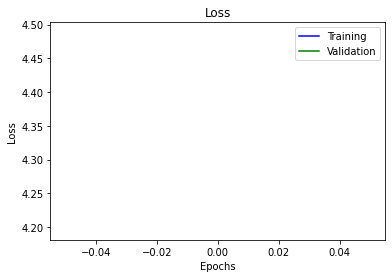

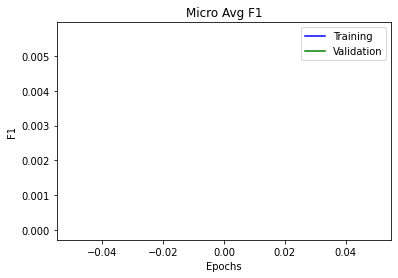

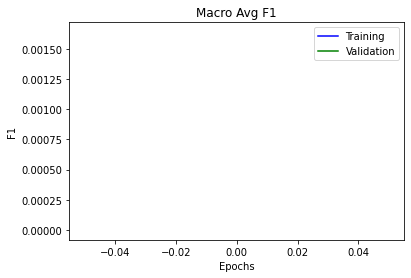

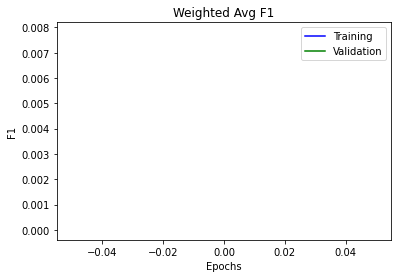

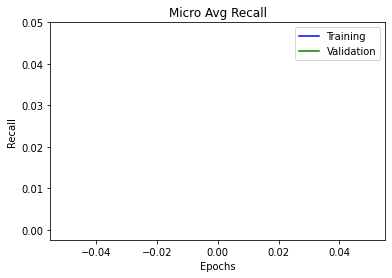

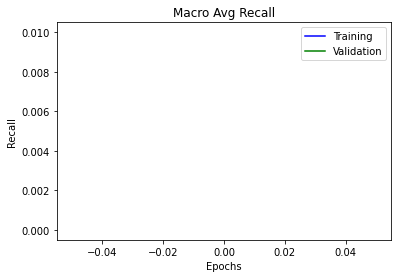

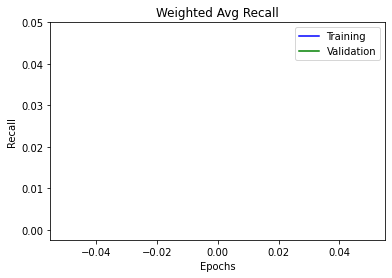

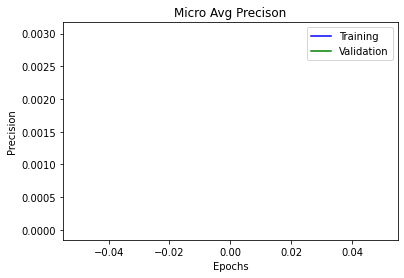

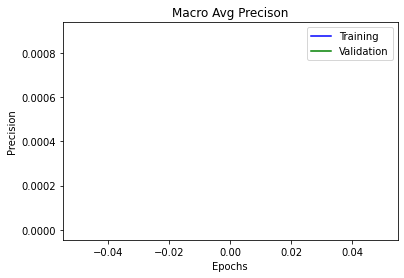

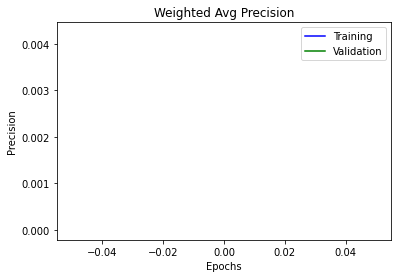

In [126]:
if (config.train_model):
    tokenizer = BertTokenizer.from_pretrained(config.tokenizer)
    print("Training model", flush=True)
    if config.task == 'ner':
        trainLoader, label_weights = load_train_data(tokenizer)
        validationLoader, _ = load_validation_data(tokenizer)
    else:
        trainLoader = load_train_data(tokenizer)
        validationLoader = load_validation_data(tokenizer)
    
    epochs = config.epochs


    if(config.task == 'mlm'):
        model = BertForMaskedLM.from_pretrained(config.saved_model_path)
    elif(config.task == 'ner'):
        BERTconfig = BertConfig.from_pretrained(config.saved_model_path, num_labels=num_ner_labels, tokenizer = tokenizer)
        if (config.use_gnn):
        #model = models.SynBertForNer.from_pretrained(config.saved_model_path, num_node_features=1, num_labels = num_ner_labels, num_att_heads = 2, num_layers = 3, from_tf = False, config = BERTconfig, low_cpu_mem_usage=True)
            model = models.SynBertForNer(bert_config = BERTconfig, bert_model = config.saved_model_path, num_node_features=768, num_labels = num_ner_labels, num_edge_attrs = 54, num_att_heads = config.num_att_heads, num_layers = config.num_layers, label_weights = label_weights)
        else:
            model = models.BertForNer.from_pretrained(config.saved_model_path, from_tf = False, config = BERTconfig)
    device =  torch.device('cpu')
    # Move model to device
    model.to(device)

    from torch.optim import AdamW
    from torch.optim.lr_scheduler import LinearLR
    # initialize optimizer
    optim = AdamW(model.parameters(), lr=config.learning_rate)
    # Initialize learning rate scheduler
    lr_scheduler = LinearLR(optim, start_factor=1.0, end_factor=0.3, total_iters=5, verbose=True)
    train_writer = SummaryWriter(log_dir=tensorboard_dir+"training")
    validation_writer = SummaryWriter(log_dir=tensorboard_dir+"validation")

    epoch_losses_train = []
    micro_precisions_train = []
    micro_recalls_train = []
    micro_f1s_train = []
    macro_precisions_train = []
    macro_recalls_train = []
    macro_f1s_train = []
    weighted_precisions_train = []
    weighted_recalls_train = []
    weighted_f1s_train = []

    epoch_losses_validation = []
    micro_precisions_val = []
    micro_recalls_val = []
    micro_f1s_val = []
    macro_precisions_val = []
    macro_recalls_val = []
    macro_f1s_val = []
    weighted_precisions_val = []
    weighted_recalls_val = []
    weighted_f1s_val = []

    for epoch in range(epochs):
        #epoch_losses_train.append(trainModel(epoch, trainLoader, train_writer))
        #epoch_losses_validation.append(validateModel(epoch, validationLoader, validation_writer))

        epoch_loss_train, micro_precision_train, micro_recall_train, micro_f1_train, macro_precision_train, macro_recall_train, macro_f1_train, weighted_precision_train, weighted_recall_train, weighted_f1_train = runModel(data_loader = trainLoader, model = model, device = device, tokenizer = tokenizer, mode = 'Train', writer = train_writer, results_dir = results_dir, epoch=epoch, optimizer=optim)
        epoch_losses_train.append(epoch_loss_train)

        micro_precisions_train.append(micro_precision_train)
        micro_recalls_train.append(micro_recall_train)
        micro_f1s_train.append(micro_f1_train)

        macro_precisions_train.append(macro_precision_train)
        macro_recalls_train.append(macro_recall_train)
        macro_f1s_train.append(macro_f1_train)

        weighted_precisions_train.append(weighted_precision_train)
        weighted_recalls_train.append(weighted_recall_train)
        weighted_f1s_train.append(weighted_f1_train)

        epoch_loss_val, micro_precision_val, micro_recall_val, micro_f1_val, macro_precision_val, macro_recall_val, macro_f1_val, weighted_precision_val, weighted_recall_val, weighted_f1_val = runModel(data_loader = validationLoader,  tokenizer = tokenizer, model = model, device = device, mode = 'Validation', writer = validation_writer, results_dir = results_dir, epoch=epoch, optimizer=optim)
        epoch_losses_validation.append(epoch_loss_val)

        micro_precisions_val.append(micro_precision_val)
        micro_recalls_val.append(micro_recall_val)
        micro_f1s_val.append(micro_f1_val)

        macro_precisions_val.append(macro_precision_val)
        macro_recalls_val.append(macro_recall_val)
        macro_f1s_val.append(macro_f1_val)

        weighted_precisions_val.append(weighted_precision_val)
        weighted_recalls_val.append(weighted_recall_val)
        weighted_f1s_val.append(weighted_f1_val)

        # Decrease learning rate
        lr_scheduler.step()
        if (activeMode == 'prod' and config.use_gnn == False):
            last_epoch = epoch-1
            if last_epoch < 0:
                last_epoch = 0
            # Save model after each epoch
            trained_models_dir = trained_models_dir.replace(f"_E{last_epoch}_", f"_E{epoch}_")
            trained_models_dir = utils.createNumberedDir(trained_models_dir)
            model.save_pretrained(save_directory=trained_models_dir)

        if epoch > 5:
            print("Model evaluation\n", flush = True)
            test_loader, _ = load_test_data(tokenizer)
            runModel(data_loader = test_loader, tokenizer = tokenizer, model = model, device = device, mode = 'Test', results_dir=results_dir, epoch= epoch)
    
    train_writer.close()
    validation_writer.close()
    prof.stop()
    # Save epoch loss plots
    plt.figure()
    plt.plot(range(0,epochs), epoch_losses_train, 'b', label='Training')
    plt.plot(range(0,epochs), epoch_losses_validation, 'g', label='Validation')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(results_dir +"/loss.png", facecolor='white', transparent=False)
    plt.show()


    # # Save micro f1 plot
    plt.figure()
    plt.plot(range(0,epochs), micro_f1s_train, 'b', label='Training')
    plt.plot(range(0,epochs), micro_f1s_val, 'g', label='Validation')
    plt.title('Micro Avg F1')
    plt.xlabel('Epochs')
    plt.ylabel('F1')
    plt.legend()
    plt.savefig(results_dir +"/f1_micro.png", facecolor='white', transparent=False)

    # # Save macro f1 plot
    plt.figure()
    plt.plot(range(0,epochs), macro_f1s_train, 'b', label='Training')
    plt.plot(range(0,epochs), macro_f1s_val, 'g', label='Validation')
    plt.title('Macro Avg F1')
    plt.xlabel('Epochs')
    plt.ylabel('F1')
    plt.legend()
    plt.savefig(results_dir +"/f1_macro.png", facecolor='white', transparent=False)
    # #plt.show()

    # # Save weighted f1 plot
    plt.figure()
    plt.plot(range(0,epochs), weighted_f1s_train, 'b', label='Training')
    plt.plot(range(0,epochs), weighted_f1s_val, 'g', label='Validation')
    plt.title('Weighted Avg F1')
    plt.xlabel('Epochs')
    plt.ylabel('F1')
    plt.legend()
    plt.savefig(results_dir +"/f1_weighted.png", facecolor='white', transparent=False)
    # #plt.show()

    # # Save micro recall plot
    plt.figure()
    plt.plot(range(0,epochs,1), micro_recalls_train, 'b', label='Training')
    plt.plot(range(0,epochs,1), micro_recalls_val, 'g', label='Validation')
    plt.title('Micro Avg Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.savefig(results_dir +"/recall_micro.png", facecolor='white', transparent=False)
    # #plt.show()

    # # Save macro recall plot
    plt.figure()
    plt.plot(range(0,epochs,1), macro_recalls_train, 'b', label='Training')
    plt.plot(range(0,epochs,1), macro_recalls_val, 'g', label='Validation')
    plt.title('Macro Avg Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.savefig(results_dir +"/recall_macro.png", facecolor='white', transparent=False)
    # #plt.show()

    # # Save weighted recall plot
    plt.figure()
    plt.plot(range(0,epochs,1), weighted_recalls_train, 'b', label='Training')
    plt.plot(range(0,epochs,1), weighted_recalls_val, 'g', label='Validation')
    plt.title('Weighted Avg Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.legend()
    plt.savefig(results_dir +"/recall_weighted.png", facecolor='white', transparent=False)
    # #plt.show()

    # # Save micro precision plot
    plt.figure()
    plt.plot(range(0,epochs,1), micro_precisions_train, 'b', label='Training')
    plt.plot(range(0,epochs,1), micro_precisions_val, 'g', label='Validation')
    plt.title('Micro Avg Precison')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.savefig(results_dir +"/precision_micro.png", facecolor='white', transparent=False)

    # # Save macro precision plot
    plt.figure()
    plt.plot(range(0,epochs,1), macro_precisions_train, 'b', label='Training')
    plt.plot(range(0,epochs,1), macro_precisions_val, 'g', label='Validation')
    plt.title('Macro Avg Precison')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.savefig(results_dir +"/precision_macro.png", facecolor='white', transparent=False)

    #  # Save weighted precision plot
    plt.figure()
    plt.plot(range(0,epochs,1), weighted_precisions_train, 'b', label='Training')
    plt.plot(range(0,epochs,1), weighted_precisions_val, 'g', label='Validation')
    plt.title('Weighted Avg Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.savefig(results_dir +"/precision_weighted.png", facecolor='white', transparent=False)
    # #plt.show()


    #plt.show()

# Model evaluation

In [ ]:
#print("Model evaluation\n", flush = True)

In [127]:
test_loader, _ = load_test_data(tokenizer)
runModel(data_loader = test_loader, tokenizer = tokenizer, model = model, device = device, mode = 'Test', results_dir=results_dir)

Test Data
Loading syntax graphs: from file en_gum-ud-test-bert-base-cased.syntree
num graphs 20
Example syntax graphs:
[Data(x=[12, 768], edge_index=[2, 11], edge_attr=[11, 54]), Data(x=[9, 768], edge_index=[2, 8], edge_attr=[8, 54])]
[{0: 2, 1: 1, 2: 4, 3: 3, 4: 6, 5: 7, 6: 5, 7: 9, 8: 10, 9: 8, 10: 11}, {0: 1, 1: 3, 2: 4, 3: 6, 4: 5, 5: 2, 6: 8, 7: 7}]
Loading NER labels from ./data/ud/UD_English-GUM/**/*-test-orig.ner
en_gum-ud-test-orig.ner
num sentences: 20
Example of NER labels: [[['The', 'O'], ['prevalence', 'O'], ['of', 'O'], ['discrimination', 'O'], ['across', 'O'], ['racial', 'O'], ['groups', 'O'], ['in', 'O'], ['contemporary', 'O'], ['America', 'S-GPE'], [':', 'O']], [['Results', 'O'], ['from', 'O'], ['a', 'O'], ['nationally', 'O'], ['representative', 'O'], ['sample', 'O'], ['of', 'O'], ['adults', 'O']]]
Excluded 0 sentences longer than sequence length
Excluded 0 items with sentence != graph
Deleted items: []
20 sentences, 20 graphs, 10 batches of size 2

Control example of 

100%|██████████| 10/10 [00:10<00:00,  1.08s/it]

***** Test results *****
Task: ner
Model path: bert-base-cased
Data path: ./data/ud/UD_English-GUM/
Tokenizer: bert-base-cased
Batch size: 2
Epoch: None
Learning rate: 3e-05
Sequence length: 96
Training: True
Num Threads: 4
Num Sentences: 20
Max Grad Norm: 0.0
Use GNN: True
Num layers: 4
Num attention heads: 2
Use label weights: True
              precision    recall  f1-score   support

    CARDINAL     0.0000    0.0000    0.0000        17
        CLS]     0.0000    0.0000    0.0000         0
        DATE     0.0000    0.0000    0.0000         0
       EVENT     0.0000    0.0000    0.0000         0
         FAC     0.0000    0.0000    0.0000         0
         GPE     0.0135    0.5000    0.0263         2
         LAW     0.0000    0.0000    0.0000         0
         LOC     0.0000    0.0000    0.0000         0
        NORP     0.0000    0.0000    0.0000         1
     ORDINAL     0.0000    0.0000    0.0000         0
         ORG     0.0000    0.0000    0.0000         0
     PERCENT   


/home/shrdlu/cdaniel/venv_syntrans/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [CLS] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/shrdlu/cdaniel/venv_syntrans/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: [SEP] seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/shrdlu/cdaniel/venv_syntrans/lib/python3.8/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: <START> seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/home/shrdlu/cdaniel/venv_syntrans/lib/python3.8/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("Finished run")

In [ ]:
# Copy log file into results folder
import shutil
shutil.copy("./logs/syngnn_main.log", results_dir)

In [ ]:
#confusion_matrix = metrics.confusion_matrix(references_all, predictions_all, labels=labels)
#print(confusion_matrix)
#disp = metrics.ConfusionMatrixDisplay(references_all, predictions_all, labels=labels)
#disp.plot()

In [ ]:
N = 600000
bincount = np.array([50000, 150000,400000,1,1,1,1,1])
nc = 8
result = N/(nc*bincount) 
print(result)

In [65]:


x = datetime.datetime.now()
print(x.strftime("%m_%d_"))
print(x.strftime("%c"))

09_20_
Tue Sep 20 17:17:09 2022
